# Model Checking

This notebook checks the model we built in [the previous notebook](http://localhost:8888/notebooks/w03-07b-pymc3-model.ipynb) for convergence. We will rebuild the model below, for explanations, please see the previous notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import statsmodels.api as sm
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Load Data

In [3]:
try:
    leinhardt_df = pd.read_csv("Leinhardt.csv")
except:
    leinhardt_df = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/carData/Leinhardt.csv")
    leinhardt_df.to_csv("Leinhardt.csv")
    
leinhardt_df.head()

,Unnamed: 0,Unnamed: 0.1,income,infant,region,oil
0,0,Australia,3426,26.7,Asia,no
1,1,Austria,3350,23.7,Europe,no
2,2,Belgium,3346,17.0,Europe,no
3,3,Canada,4751,16.8,Americas,no
4,4,Denmark,5029,13.5,Europe,no


In [4]:
leinhardt_df["log_income"] = np.log(leinhardt_df["income"])
leinhardt_df["log_infant"] = np.log(leinhardt_df["infant"])

leinhardt_df.dropna(subset=["log_income", "log_infant"], inplace=True)

In [5]:
x = leinhardt_df["log_income"].values
y = leinhardt_df["log_infant"].values
x.shape, y.shape

((101,), (101,))

## Model #1

In [6]:
init_params = {
    "mu_0": 0,
    "sigma_0": 1e6,
    "alpha_0": 2.5,
    "beta_0": 0.04
}

n_tune = 1000
n_iter = 5000
n_chains = 3

with pm.Model() as linreg_model:
    beta = pm.Normal("beta", mu=init_params["mu_0"], sigma=init_params["sigma_0"], shape=2)
    sigma2 = pm.InverseGamma("sigma2", alpha=init_params["alpha_0"], beta=init_params["beta_0"])

    sigma = np.sqrt(sigma2)
    mu = beta[0] + beta[1] * x
    
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
    
    trace = pm.sample(n_iter, tune=n_tune, chains=n_chains)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [sigma2, beta]
Sampling 3 chains, 0 divergences: 100%|██████████| 18000/18000 [00:17<00:00, 1054.90draws/s]


## Check for Convergence

### Traceplots

* Traceplots don't show any long term trends -- indicates convergence.

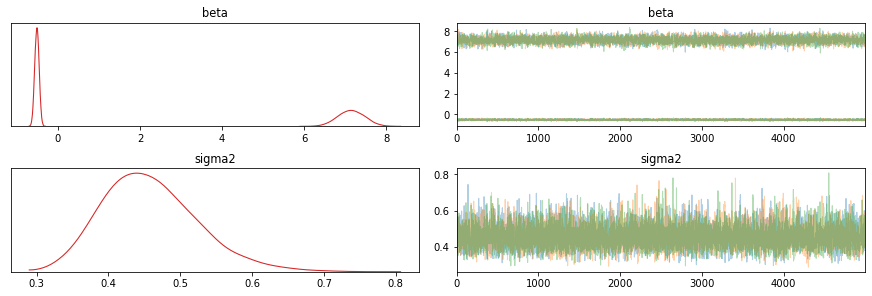

In [7]:
_ = pm.traceplot(trace, combined=True)

## Gelman-Rubin Diagnostic

* Gelman-Rubin diagnostic reports potential scale reduction factors very close to 1 -- indicates convergence.

In [8]:
pm.gelman_rubin(trace)

<xarray.Dataset>
Dimensions:     (beta_dim_0: 2)
Coordinates:
  * beta_dim_0  (beta_dim_0) int64 0 1
Data variables:
    beta        (beta_dim_0) float64 1.001 1.001
    sigma2      float64 1.001

## Autocorrelation

* Autocorrelation values are extremely small -- indicates convergence

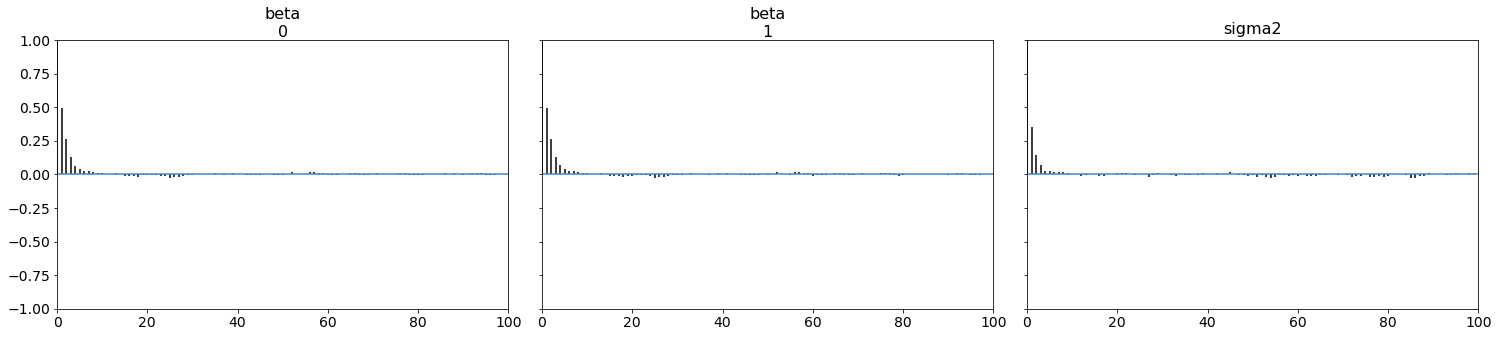

In [9]:
_ = pm.autocorrplot(trace, combined=True)

In [10]:
def autocorr(x, t=10):
    return np.corrcoef(np.array([x[:-t], x[t:]]))[0,1]

beta = trace.get_values("beta")
beta_0, beta_1 = beta[:, 0], beta[:, 1]
sigma2 = trace.get_values("sigma2")
print("({:.5f}, {:.5f}, {:.5f})".format(autocorr(beta_0), autocorr(beta_1), autocorr(sigma2)))

(0.00977, 0.01144, 0.00659)


## Effective Sample Size

Effective sample size for $\beta_0$, $\beta_1$, and $\sigma_2$ are 4,881, 4,869, 6,843 out of 15,000 (5,000 iterations in 3 chains) iterations. So this indicates that our variables did not mix that well, but this is still okay, because we are not trying to compute confidence intervals from these estimates. If we wanted to do that, we would need more effective samples, hence we would run the chains for larger number iterations.

In [11]:
pm.effective_n(trace)

<xarray.Dataset>
Dimensions:     (beta_dim_0: 2)
Coordinates:
  * beta_dim_0  (beta_dim_0) int64 0 1
Data variables:
    beta        (beta_dim_0) float64 4.678e+03 4.665e+03
    sigma2      float64 6.451e+03

## Summary

Results from sampling is close to the reference model (analytical solution) where we used a flat prior.

In [12]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta[0],7.147,0.320,6.527,7.721,0.005,0.003,4689.0,4689.0,4678.0,5519.0,1.0
beta[1],-0.512,0.052,-0.608,-0.415,0.001,0.001,4673.0,4673.0,4665.0,5751.0,1.0
sigma2,0.459,0.066,0.342,0.585,0.001,0.001,6305.0,6118.0,6451.0,5990.0,1.0


## Residual Analysis

Residuals are defined as the difference between the actual observation (label) and the model's prediction. With residuals, we are looking for any sign that the model is not linear, it is not normally distributed, or that the observations are not independent from each other, at least conditionally on the explanatory variables.

For reference, we will plot a linear model using the reference variables (i.e., not on log scale).

### Reference Model

In [13]:
x_ref = leinhardt_df["income"].values
X_ref = np.vstack((x_ref, np.ones(len(x_ref)))).T

y_ref = leinhardt_df["infant"].values

model_ref = sm.OLS(y_ref, X_ref).fit()
model_ref.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     12.14
Date:                Thu, 27 Feb 2020   Prob (F-statistic):           0.000735
Time:                        19:11:34   Log-Likelihood:                -592.34
No. Observations:                 101   AIC:                             1189.
Df Residuals:                      99   BIC:                             1194.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0209      0.006     -3.485      0.001      -0.033      -0.009
const        110.4211     10.539     10.478      0.000      89.510     131.332
==============================================================================
Omnibus:                      111.162   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1809.816
Skew:                           3.648   Prob(JB):                         0.00
Kurtosis:                      22.412   Cond. No.                     2.16e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Residuals for Reference Model

* __Residual plot__ -- there does not appear to be a pattern in the residual plot, so reasonable to assume that the data for `income` and data for `infant` mortality are independent.
* __Residual vs Predictions plot__ -- we don't want to see a pattern, but there seems to be a pattern here. First we see a downward trend of the residual as the value of the predictions get higher, and our assumption that residual variance is same for all observations appears to be wildly incorrect.
* __QQNorm plot__ -- check assumption of normality, plots the theoretical quantiles of a normal distribution on the X-axis and the actual residuals on the y-axis. Results should be approximately linear to satisfy normality. Actual result is curved, so the assumption of normality does not hold for the reference model.

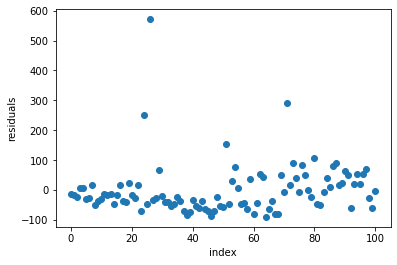

In [14]:
preds_ref = model_ref.predict(X_ref)
# residuals = y_ref - pred_ref
resids_ref = model_ref.resid

plt.xlabel("index")
plt.ylabel("residuals")
_ = plt.scatter(np.arange(len(preds_ref)), resids_ref)

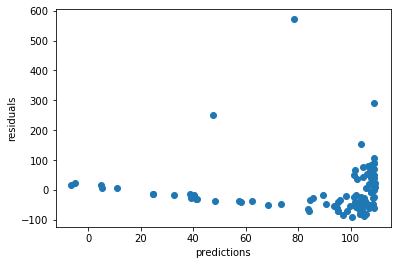

In [15]:
plt.xlabel("predictions")
plt.ylabel("residuals")
_ = plt.scatter(preds_ref, resids_ref)

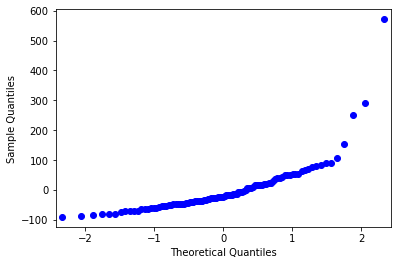

In [16]:
_ = sm.qqplot(resids_ref)

### Residuals for Bayesian fitted model

* __Residual plot__ -- no pattern, so `log_income` and `log_infant` are independent.
* __Residual vs Predictions plot__ -- Again no pattern here, although variance in residual appears to increase as we go from small to large predicted values.
* __QQNorm plot__ -- straight line, so assumption of normality met.

All three plots show 2 outliers.

In [17]:
betas = np.mean(trace.get_values("beta", combine=True), axis=0)
X = np.vstack((np.ones(x.shape[0]), x)).T

preds = np.matmul(X, betas)
resids = y - preds

print(X.shape, betas.shape, preds.shape, resids.shape)
print("betas:", betas)

(101, 2) (2,) (101,) (101,)
betas: [ 7.14697723 -0.51204434]


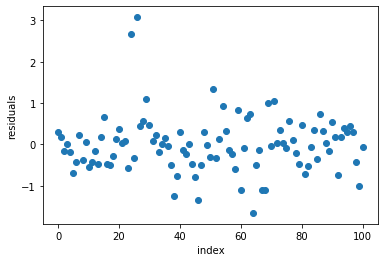

In [18]:
plt.xlabel("index")
plt.ylabel("residuals")
_ = plt.scatter(np.arange(len(preds)), resids)

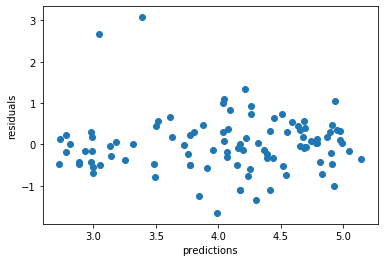

In [19]:
plt.xlabel("predictions")
plt.ylabel("residuals")
_ = plt.scatter(preds, resids)

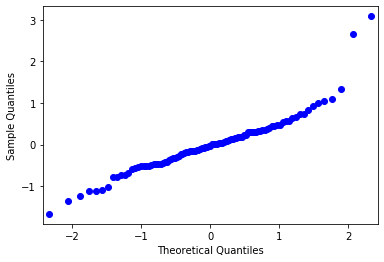

In [20]:
_ = sm.qqplot(resids)

## Outliers

Compute the residuals and add a column into the dataframe.

$$ prediction = \beta_0 + \beta_1 * log(income) $$
$$ residual = log(infant) - prediction $$

Then sort descending by `residual`. The outliers with high actual mortality compared to the predicted mortality based on income are Saudi Arabia and Libya.

At times, it may be worth removing the outliers and rerunning the model.

In [21]:
leinhardt_df["residuals"] = leinhardt_df["log_infant"] - (betas[0] + betas[1] * leinhardt_df["log_income"])

sorted_leinhardt_df = leinhardt_df.sort_values(by=["residuals"], ascending=False)
sorted_leinhardt_df.reset_index()
sorted_leinhardt_df.head(2)

,Unnamed: 0,Unnamed: 0.1,income,infant,region,oil,log_income,log_infant,residuals
27,27,Saudi.Arabia,1530,650.0,Asia,yes,7.333023,6.476972,3.084828
25,25,Libya,3010,300.0,Africa,yes,8.009695,5.703782,2.658124
